<a href="https://colab.research.google.com/github/saskiad/AMATH_BrainObservatory_Tutorial/blob/master/VisualCoding/2_Compare_neurons%20updates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook will compare tuning curves of different neurons using the Allen Brain Observatory data
    
In the first notebook, we computed the tuning curve of one neuron to the `Drifting Gratings` stimulus. Here we will do this for many neurons so we can see the diversity of visual responses.


In [5]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }

# run only once per runtime/session, and only if running in colab
# the runtime will need to restxart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

import time
print("Runtime is now restarting...")
print("You can ignore the error message [Your session crashed for an unknown reason.]")
time.sleep(5)
exit()

### Standard imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Allen Brain Observatory set up

In [6]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

In the last notebook we walked through computing the two dimensional tuning curve for just one neuron. Here we are going to do this for many neurons. To make this easier, begin by writing a function to compute the tuning curve, and plot the heatmap.

You will need the `get_dff_traces_and_stim_table` function that we used in the previous notebook as part of this so we've provided it here:


In [3]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus):
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])

    #get the session_id for that session
    session_id = exps[0]['id']

    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)

    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]

    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)

    #return everything
    return (timestamps, dff_trace, stim_table)

# **Exercise 1:**
Write a function to compute and plot the z-score of the tuning curve for a defined cell_id to the drifting grating stimulus. I've outlined the function you need to write below - look back at your work in the previous notebook and do some strategic copying and pasting.



In [ ]:
def compute_tuning(cell_id):
    #get the dff_traces and the stimulus table using the function above

    #compute the cell response

    #get the orivals and tfvals

    #compute the tuning array

    #compute the z-score

    #plot the heatmap of the tuning array

In [7]:
#@title Click to see solution {display-mode: "form" }

def compute_tuning(cell_id):
    #get the dff_traces and the stimulus table using the function above
    timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

    #compute the cell response
    cell_response= np.zeros((len(stim_table),3))
    for i in range(len(stim_table)):
        cell_response[i,0] = stim_table.orientation[i]
        cell_response[i,1] = stim_table.temporal_frequency[i]
        cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

    #get the orivals and tfvals
    all_ori = np.unique(cell_response[:,0])
    orivals = all_ori[np.isfinite(all_ori)]
    tfvals = np.unique(cell_response[:,1])
    tfvals = tfvals[np.isfinite(tfvals)]

    #compute the tuning array
    tuning_array = np.empty((8,5))
    for i,tf in enumerate(tfvals):
        tf_trials = cell_response[:,1]==tf
        subset = cell_response[tf_trials]
        for j,ori in enumerate(orivals):
            trials = subset[:,0]==ori
            tuning_array[j,i] = subset[trials,2].mean()

    #compute the z-score
    tuning_array_z = (tuning_array - tuning_array.mean())/tuning_array.std()

    #plot the heatmap of the tuning array
    plt.imshow(tuning_array_z, cmap="RdBu_r", vmax=tuning_array_z.max(), vmin=-1*tuning_array_z.max())
    plt.xticks(range(5), tfvals)
    plt.yticks(range(8), orivals)
    plt.xlabel("TF")
    plt.ylabel("Direction")
    cbar = plt.colorbar()
    cbar.set_label("Z score (std dev)")
    plt.title("Cell "+str(cell_id))
    plt.show()

    return tuning_array

# **Exercise 2:**
Test your function by computing and plotting the tuning curve for the neuron we looked at in the preious notebook, cell_id: 541513979


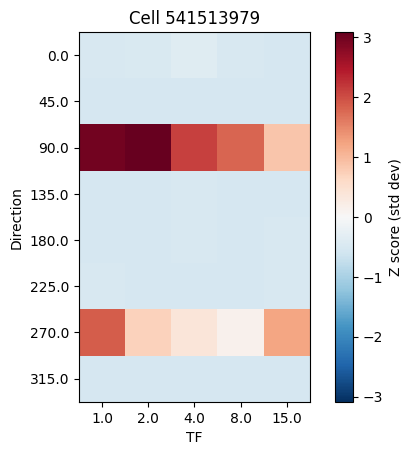

In [8]:
#@title Click to see solution {display-mode: "form" }
tuning_array = compute_tuning(541513979)

# **Exercise 3:**
Compute and plot the tuning curves for cell_ids 541511905, 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607.
(Note: these are all neurons from the same session as the neuron above)

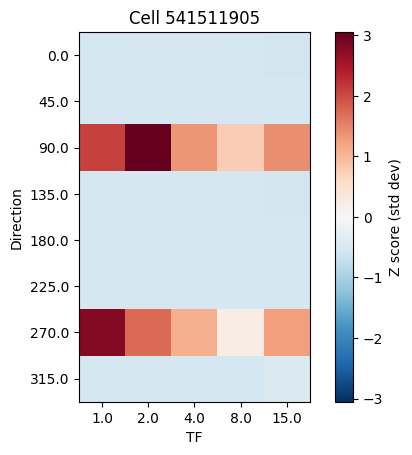

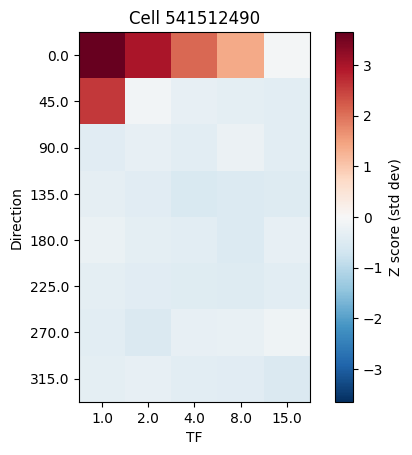

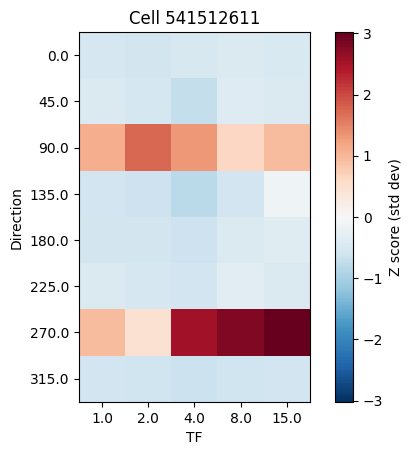

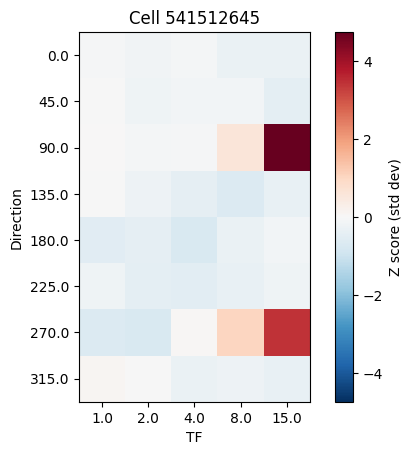

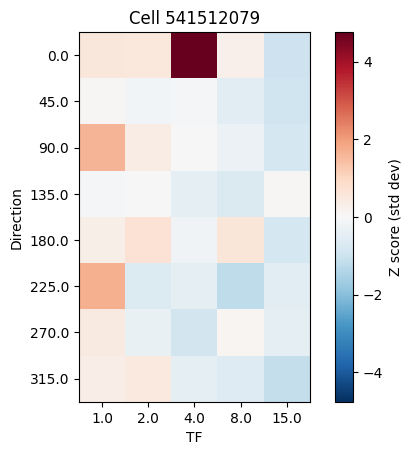

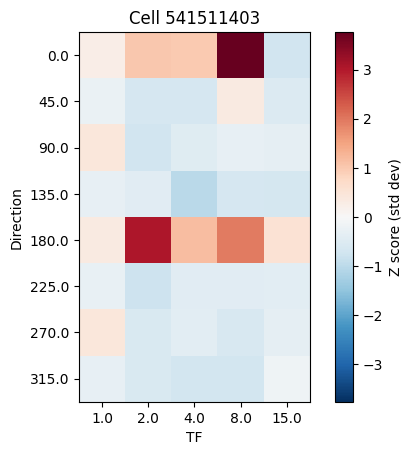

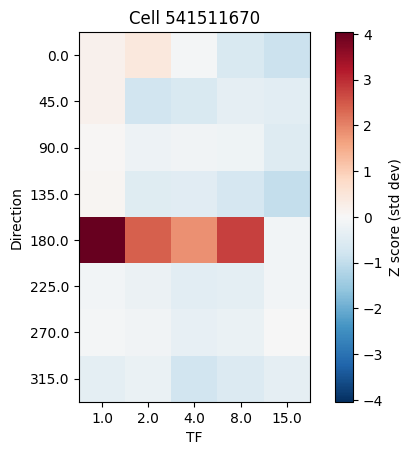

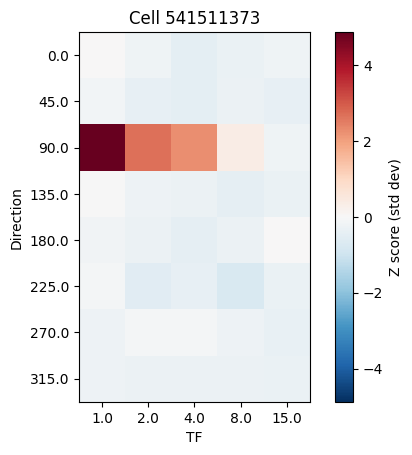

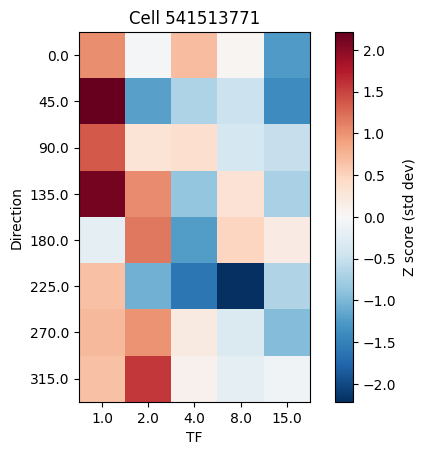

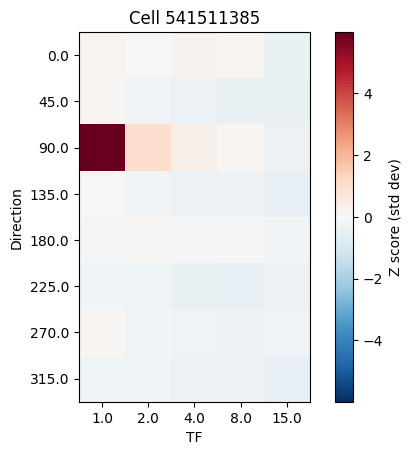

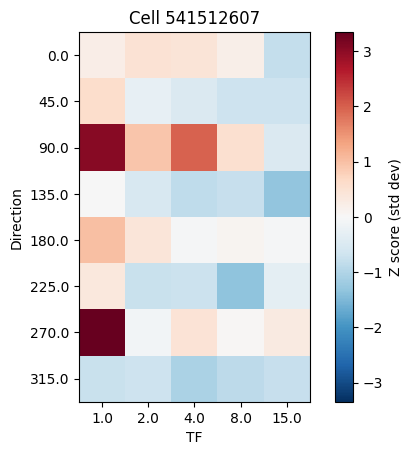

In [ ]:
#@title Click to see solution {display-mode: "form" }
cells = [541511905, 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607]
for cell_id in cells:
    compute_tuning(cell_id)

What are some things you notice when looking at these? What are some of the ways different neurons have different tuning curves?

Neurons can differ in which direction of motion they prefer, whether they are orientation selective (i.e. they respond ~equally to one direction and its opposite, thus responding to the orientation of the grating more than the direction of motion), respond broadly to many directions, or are slectively responsive to only one direction. Neurons can also differ in their temporal frequency tuning - which temporal frequency they have their preferred response to. Neurons also differ in the strength of their response. This can be both in terms of the absolute value of the response, but also the relative strength of the response (e.g. the difference between the response to the preferred condition and the response to non-preffered or blank sweep conditions). This can be measured in various ways and can be useful for determine the significance of the neuron's response. Does the neuron actually respond to this stimulus, or is the tuning really just noise?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>All of the neurons we've looked at so far are from just one session. This means they are all from a single population of neurons in a specific mouse, that has a specific genotype and age, and that were recorded from a single brain region and a single imaging depth (i.e. cortical layer).
<p>Let's see what these details are for this session. Begin by accessing the dataset for this session, starting with our orignal cell_id. We can use the same functions from the AllenSDK that are hidden in our `get_dff_traces_and_stim_table` function.
</div>

In [9]:
cell_id = 541513979

#identify the session for a given cell id and stimulus. Get the session ID.
session_id = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])[0]['id']

#access the data for that session
data_set = boc.get_ophys_experiment_data(session_id)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We can access metadata about this session using a function called `get_metadata`
<p>
</div>

In [10]:
metadata = data_set.get_metadata()

This is a dictionary with some metadata describing this experiment. Let's see what the `keys` of the dictionary are.

In [11]:
metadata.keys()

dict_keys(['sex', 'targeted_structure', 'ophys_experiment_id', 'experiment_container_id', 'excitation_lambda', 'indicator', 'fov', 'genotype', 'session_start_time', 'session_type', 'specimen_name', 'cre_line', 'imaging_depth_um', 'age_days', 'device', 'device_name', 'pipeline_version'])

We can use this to pull some experimental details about the experiment

In [13]:
print("Mouse sex: ", metadata['sex'])
print("Mouse age: ", metadata['age_days'])
print("Mouse genotype: ", metadata["genotype"])
print("Brain region: ", metadata["targeted_structure"])
print("Imaging depth: ", metadata["imaging_depth_um"])

Mouse sex:  male
Mouse age:  121
Mouse genotype:  Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Brain region:  VISp
Imaging depth:  175


What does this mean?
<p>We recorded from a male mouse in the brain region called "VISp". This is the primary visual cortex (sometimes called "V1").
<p>The imaging depth is 175 um, which maps to layer 2/3 of the cortex.
<p>And the genotype of the mouse is a jumble of letters. The first part "Emx1-IRES-Cre" is the Cre driver that is driving the expression of the reporter in a particular subset of neurons. In this case, Emx is a pan-excitatory driver, driving expression in all excitatory neurons, but not inhibitory interneurons. What is it driving? Camk2a-tTA and Ai93(TITL-GCaMP6f). Ai93 is GCaMP6f, a genetically encoded calcium indicator. Camk2a-tTA acts to amplify the expression of Ai93. In this mouse, all excitatory neurons in cortex are expressing GCaMP6f.
<p>So the neurons we are recording in this experiment are excitatory neurons in layer 2/3 of VISp.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>In the entire Allen Brain Observatory dataset, we recorded from ~250 mice, sampling from 14 different transgenic lines, 6 cortical areas, and 4 different cortical layers. This allows us to compare responses of neurons across all these dimensions. So let's compare these Emx responses we've been looking at with some responses from neurons of other transgenic lines in VISp.
<p>The AllenSDK functions that we've been using to access our dataset allow us to use some of these metadata to identify sessions. Let's find sessions where neurons in VISp were recorded from other cell types.
<p>We will look at responses from Vip-IRES-Cre, Sst-IRES-Cre, and Pvalb-IRES-Cre. These are three different types of *inhibitory interneurons*. As such they are much sparser than the Emx neurons are, so a given session often has a small number of neurons in it (roughly a dozen) while the Emx session we were looking at before has over 200 neurons. We will just plot the tuning curves for all of the neurons in these experiments
</div>

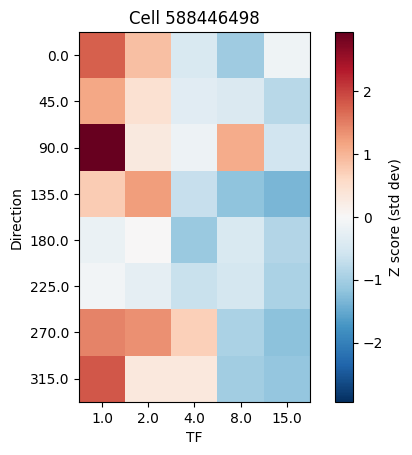

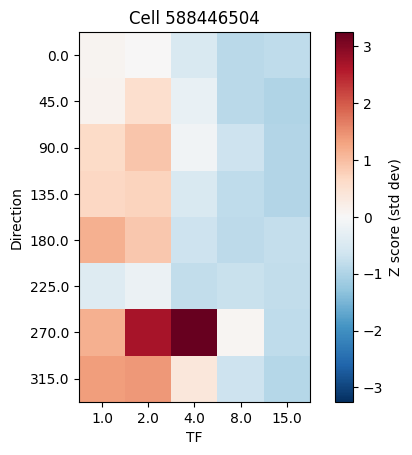

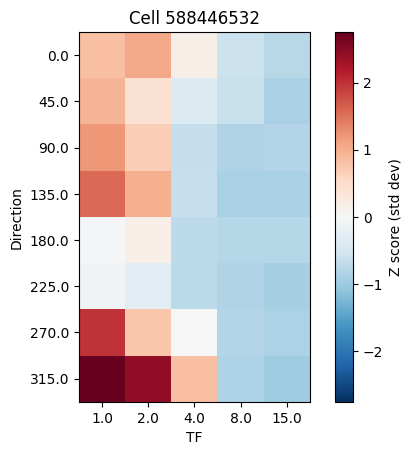

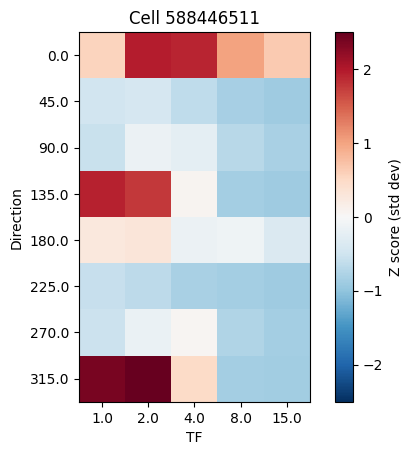

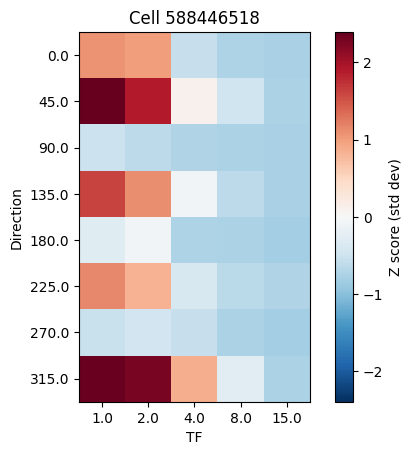

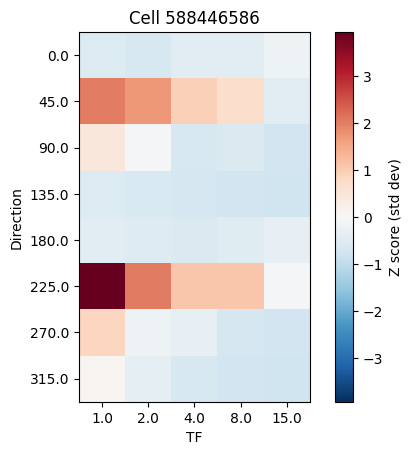

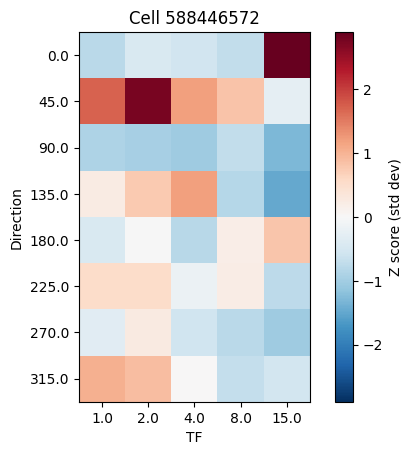

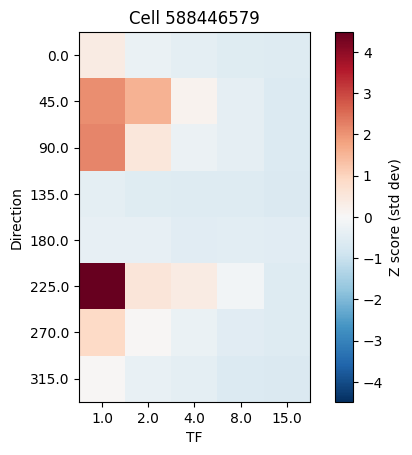

In [14]:
#first we select a session with Sst-IRES-Cre in VISp when drifting gratings are presented. There are several such experiment and we'll just pull the first one (index 0).
session_id = boc.get_ophys_experiments(cre_lines=['Sst-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']

#next get the dataset for this session
data_set = boc.get_ophys_experiment_data(session_id)

#last plot the tuning curve for all the neurons in this session using the function you wrote
for cell_id in data_set.get_cell_specimen_ids(): #iterate across all cell_ids
    compute_tuning(cell_id) #compute and plot the tuning curve

Repeat the same thing for `Pvalb-IRES-Cre`. All you need to change in the code above the is name of the cre_lines in the first line

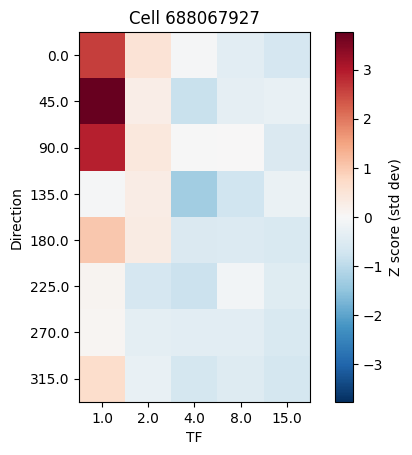

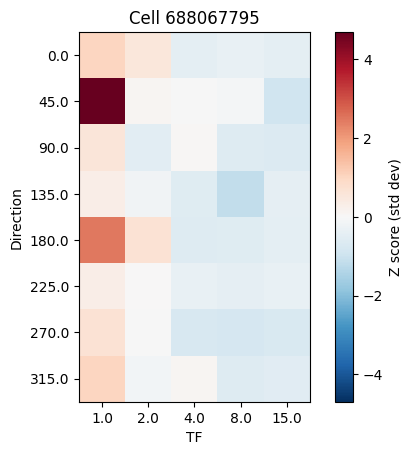

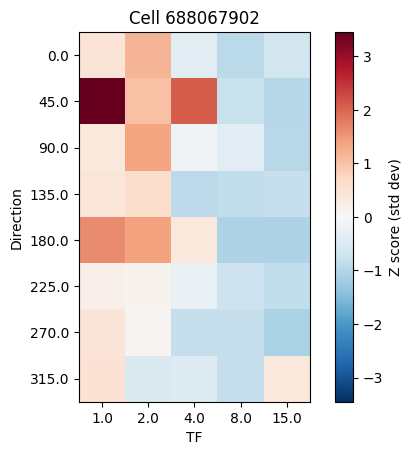

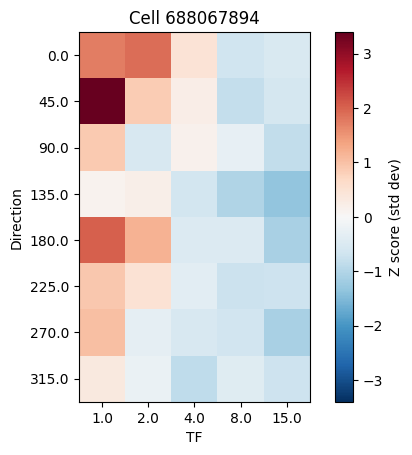

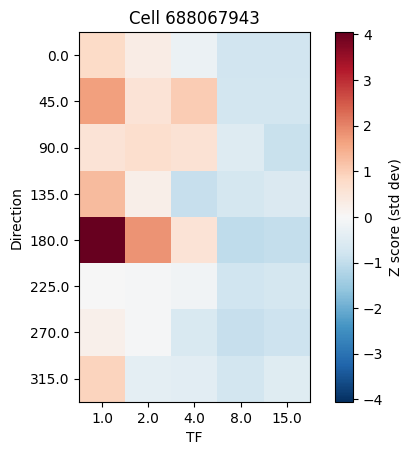

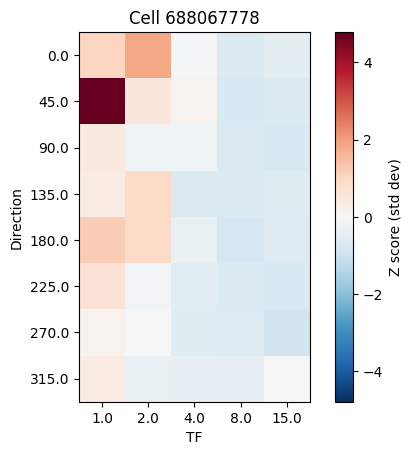

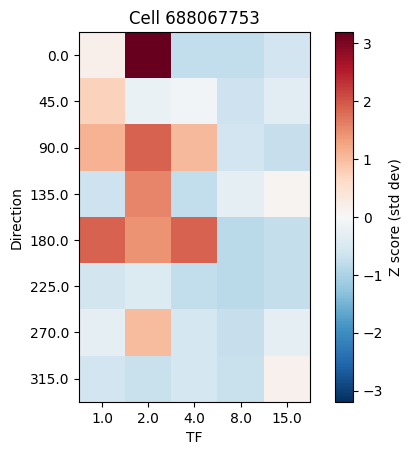

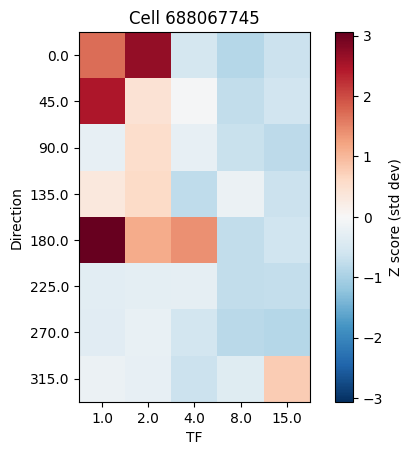

In [ ]:
session_id = boc.get_ophys_experiments(cre_lines=['Pvalb-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
for cell_id in data_set.get_cell_specimen_ids():
    compute_tuning(cell_id)

Repeat the same thing for `Vip-IRES-Cre`

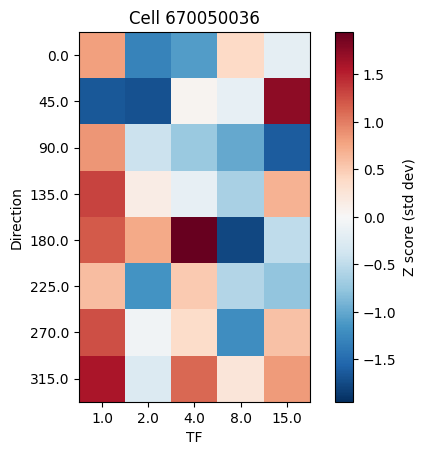

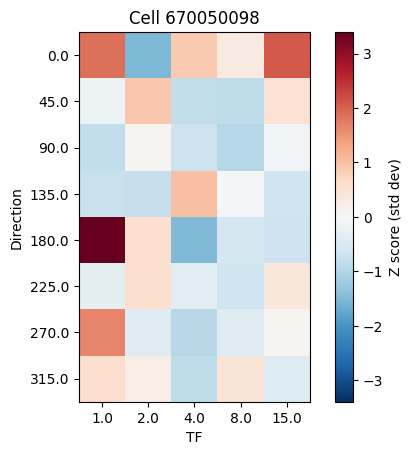

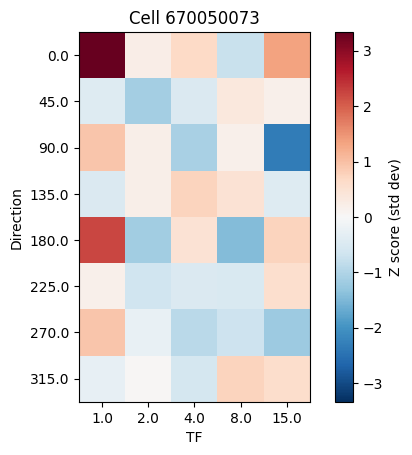

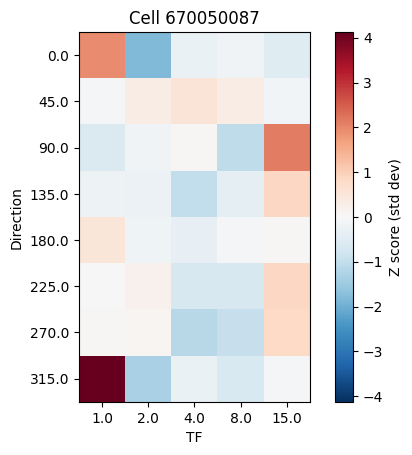

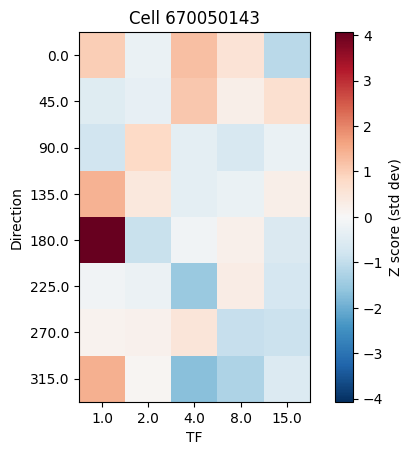

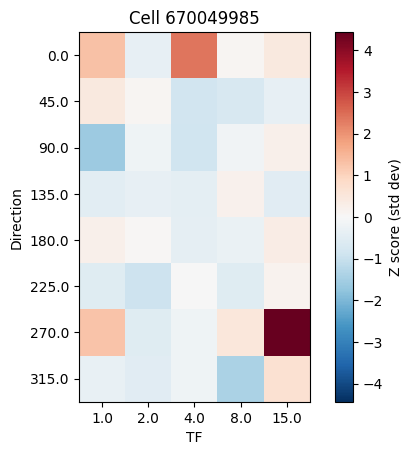

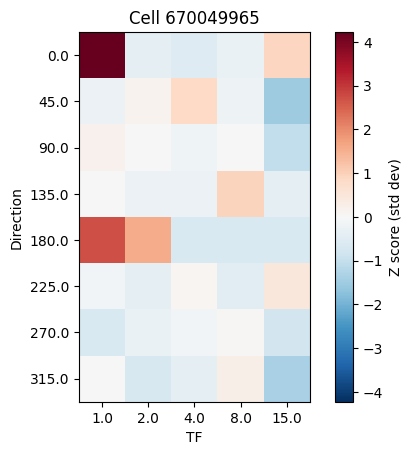

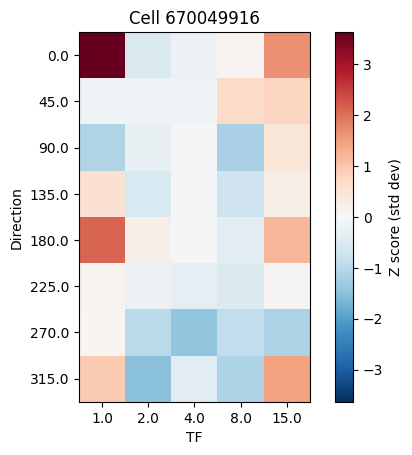

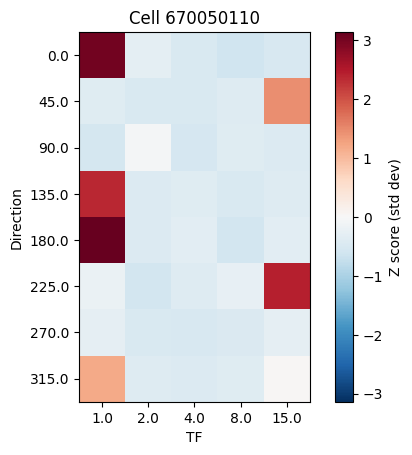

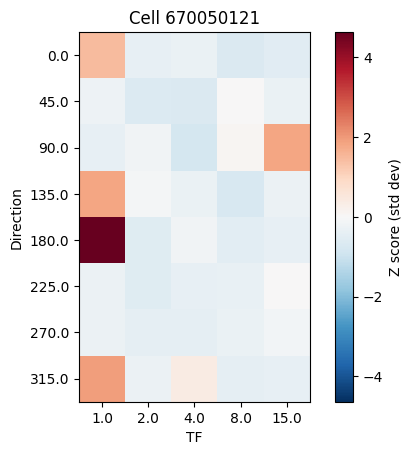

In [ ]:
session_id = boc.get_ophys_experiments(cre_lines=['Vip-IRES-Cre'], targeted_structures=['VISp'], stimuli=['drifting_gratings'])[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
for cell_id in data_set.get_cell_specimen_ids():
    compute_tuning(cell_id)

What do you notice about these tuning curves for the inhibitory interneurons? In what ways do they look similar to the Emx cells? In what ways do they look different? How consistent are the responses within each inhibitory population? Are the tuning curves of the different types of inhibitory interneurons similar to each other?